# Is it possible to predict patient No-Shows on medical appointments? Let's find out!

In [1]:
"""
Created on Wed Oct  7 09:23:47 2020

@author: Estudio
"""
#Importing libraries
import pandas as pd , matplotlib.pyplot as plt, seaborn as sns,numpy as np
fpath='KaggleV2-May-2016.csv'
#read the dataset
data=pd.read_csv(fpath)

In [3]:
# show the first 5 rows of the data
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
#show data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
# renaming columns to lowercase letters
data.columns=data.columns.map(lambda x: x.lower())
data.columns

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no-show'],
      dtype='object')

In [6]:
#parsing dates
data['scheduledday']=pd.to_datetime(data['scheduledday'],utc=True)
data['appointmentday']=pd.to_datetime(data['appointmentday'],utc=True)
data[['scheduledday','appointmentday']].dtypes

scheduledday      datetime64[ns, UTC]
appointmentday    datetime64[ns, UTC]
dtype: object

In [7]:

#extracting day of the week from the appointment day
data['dow_appointment'] = data['appointmentday'].dt.weekday
data['dow_appointment'].value_counts()

2    25867
1    25640
0    22715
4    19019
3    17247
5       39
Name: dow_appointment, dtype: int64

In [10]:
#extracting day of the week from the scheduled day
data['dow_schedule'] = data['scheduledday'].dt.weekday
data['dow_schedule'].value_counts()

1    26168
2    24262
0    23085
4    18915
3    18073
5       24
Name: dow_schedule, dtype: int64

In [11]:
#extracting month of the appointment day
data['appointment_month']=data['appointmentday'].dt.month
data.appointment_month.value_counts()

5    80841
6    26451
4     3235
Name: appointment_month, dtype: int64

In [12]:
#extracting month of the scheduled day
data['schedule_month']=data['scheduledday'].dt.month
data.schedule_month.value_counts()


5     67421
4     25339
6     13750
3      3614
2       281
12       61
1        60
11        1
Name: schedule_month, dtype: int64

In [14]:
#renaming column for convinience
data=data.rename(columns={'no-show': 'no_show'})
#retrive info about variables and vartypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   patientid          110527 non-null  float64            
 1   appointmentid      110527 non-null  int64              
 2   gender             110527 non-null  object             
 3   scheduledday       110527 non-null  datetime64[ns, UTC]
 4   appointmentday     110527 non-null  datetime64[ns, UTC]
 5   age                110527 non-null  int64              
 6   neighbourhood      110527 non-null  object             
 7   scholarship        110527 non-null  int64              
 8   hipertension       110527 non-null  int64              
 9   diabetes           110527 non-null  int64              
 10  alcoholism         110527 non-null  int64              
 11  handcap            110527 non-null  int64              
 12  sms_received       110527 non-

In [15]:
#dictionaries for mapping variables to categorical
data.gender.value_counts()
rdict={'No':0,'Yes':1,'M':0,'F':1}
data.handcap.value_counts()
rdict2={4:1,3:1,2:1}
ndict={}

#renaming neighbourhoods with less than 200 patients with 'Other'
cn=data.neighbourhood.value_counts()
for i in cn.index:
    if cn[i] < 200:
        ndict.setdefault(i,'Other')
#replacing data with new values
data["no_show"] = data['no_show'].replace(rdict)
data["gender"] = data['gender'].replace(rdict)
data["handcap"] = data['handcap'].replace(rdict2)
data["neighbourhood"] = data['neighbourhood'].replace(ndict)


In [19]:
#computing time differential between day of schedule and appointment day
data['tdelta']=abs(data['appointmentday']-data['scheduledday'])
data.tdelta[0]


Timedelta('0 days 18:38:08')

In [20]:
#convert from timedelta to numeric
data['tdelta']=pd.to_numeric(data['tdelta'])
data.tdelta[0]


67088000000000

In [21]:
#convert from nanoseconds to hours
data['tdelta']=pd.to_numeric(data['tdelta'])/(3600*1000000000)
data.tdelta[0]

18.635555555555555

In [22]:
#converting to categorical
data['categorical_tdelta'] = pd.qcut(data['tdelta'], 4)
data.categorical_tdelta.value_counts() 

(343.693, 4285.317]    27632
(11.585, 83.38]        27632
(3.271, 11.585]        27632
(83.38, 343.693]       27631
Name: categorical_tdelta, dtype: int64

In [23]:
#converting to categorical
data['categorical_age'] = pd.qcut(data['age'], 4)
data.categorical_age.value_counts()


(-1.001, 18.0]    28867
(55.0, 115.0]     27504
(18.0, 37.0]      27250
(37.0, 55.0]      26906
Name: categorical_age, dtype: int64

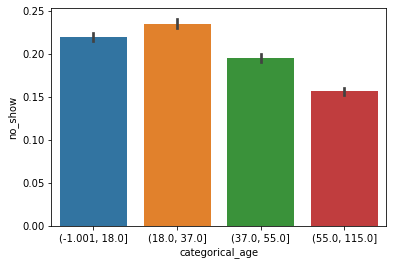

In [24]:
#Showing Appointment no-shows relationship with independent variables
#Age
data[['categorical_age', 'no_show']].groupby(['categorical_age'], as_index=False).mean()
sns.barplot(x='categorical_age',y='no_show',data=data)
plt.show()

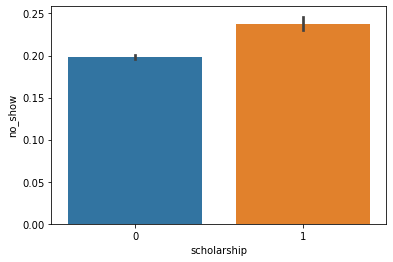

In [25]:
#Scholarship
data[['no_show', 'scholarship']].groupby(['scholarship'], as_index=False).mean()
sns.barplot(x='scholarship',y='no_show',data=data)
plt.show()


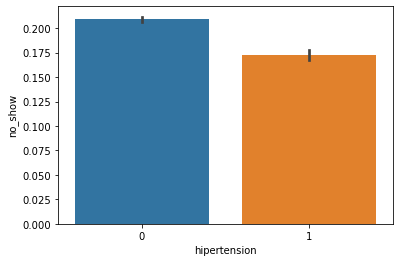

In [26]:
#Hipertension
data[['no_show', 'hipertension']].groupby(['hipertension'], as_index=False).mean()
sns.barplot(x='hipertension',y='no_show',data=data)
plt.show()


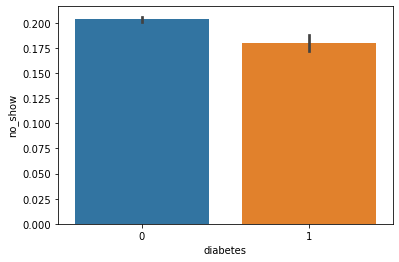

In [27]:
#Diabetes
data[['no_show', 'diabetes']].groupby(['diabetes'], as_index=False).mean()
sns.barplot(x='diabetes',y='no_show',data=data)
plt.show()


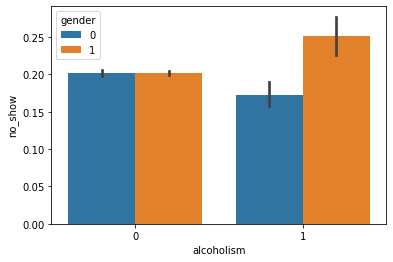

In [28]:
#Alcoholism
data[['no_show', 'alcoholism','gender']].groupby(['alcoholism','gender'], as_index=False).mean()
sns.barplot(x='alcoholism',y='no_show',hue='gender',data=data)
plt.show()


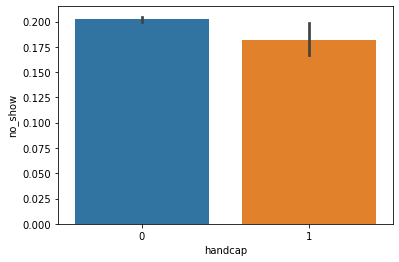

In [29]:
#Handicap
data[['no_show', 'handcap']].groupby(['handcap'], as_index=False).mean()
sns.barplot(x='handcap',y='no_show',data=data)
plt.show()


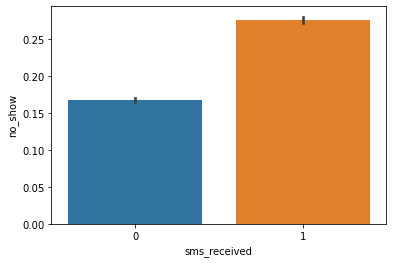

In [30]:
#Recieved SMS
data[['no_show', 'sms_received']].groupby(['sms_received'], as_index=False).mean()
sns.barplot(x='sms_received',y='no_show',data=data)
plt.show()


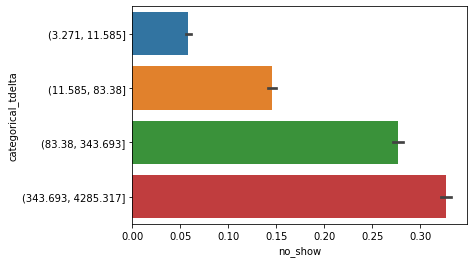

In [31]:
#Time Differential
data[['no_show', 'categorical_tdelta']].groupby(['categorical_tdelta'], as_index=False).mean()
sns.barplot(y='categorical_tdelta',x='no_show',data=data)
plt.show()


In [32]:
#Day of week of appointment
data[['no_show', 'dow_appointment']].groupby(['dow_appointment'], as_index=False).mean()


,dow_appointment,no_show
0,0,0.206471
1,1,0.200936
2,2,0.196892
3,3,0.193541
4,4,0.212261
5,5,0.230769


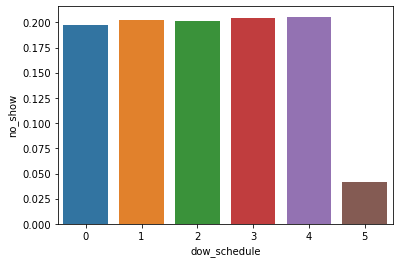

In [34]:
#Day of week of schedule
data[['no_show', 'dow_schedule']].groupby(['dow_schedule'], as_index=False).mean()
sns.barplot(x='dow_schedule',y='no_show',data=data,ci=None)
plt.show()


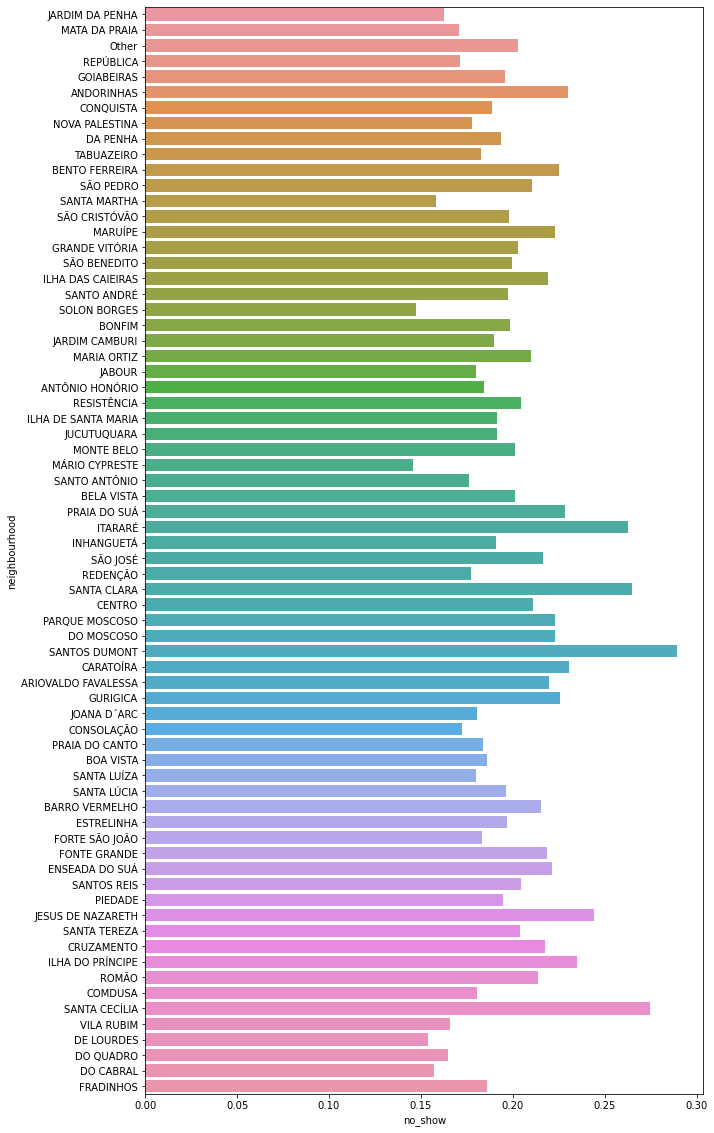

In [36]:
#Neighbourhood
data[['no_show', 'neighbourhood']].groupby(['neighbourhood'], as_index=False).mean()
plt.figure(figsize=(10,20))
sns.barplot(y='neighbourhood',x='no_show',data=data,ci=None)
plt.show()

In [37]:
 # Mapping Age
data.loc[data['age'] <= 18, 'age'] = 0
data.loc[(data['age'] > 18) & (data['age'] <= 37), 'age'] = 1
data.loc[(data['age'] > 37) & (data['age'] <= 55), 'age'] = 2
data.loc[ data['age'] > 55, 'age'] =3  

 # Mapping time Delta
data.loc[data['tdelta'] <= 11.585, 'tdelta'] = 0
data.loc[(data['tdelta'] > 11.585) & (data['tdelta'] <= 83.38), 'tdelta'] = 1
data.loc[(data['tdelta'] > 83.38) & (data['tdelta'] <= 343.693), 'tdelta'] = 2
data.loc[ data['tdelta'] > 343.693, 'tdelta'] =3  

data.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,...,handcap,sms_received,no_show,dow_appointment,dow_schedule,appointment_month,schedule_month,tdelta,categorical_tdelta,categorical_age
0,2.987250e+13,5642903,1,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,3,JARDIM DA PENHA,0,1,0,...,0,0,0,4,4,4,4,1.0,"(11.585, 83.38]","(55.0, 115.0]"
1,5.589978e+14,5642503,0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,3,JARDIM DA PENHA,0,0,0,...,0,0,0,4,4,4,4,1.0,"(11.585, 83.38]","(55.0, 115.0]"
2,4.262962e+12,5642549,1,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,3,MATA DA PRAIA,0,0,0,...,0,0,0,4,4,4,4,1.0,"(11.585, 83.38]","(55.0, 115.0]"
3,8.679512e+11,5642828,1,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,0,Other,0,0,0,...,0,0,0,4,4,4,4,1.0,"(11.585, 83.38]","(-1.001, 18.0]"
4,8.841186e+12,5642494,1,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,3,JARDIM DA PENHA,0,1,1,...,0,0,0,4,4,4,4,1.0,"(11.585, 83.38]","(55.0, 115.0]"


In [38]:
from sklearn.preprocessing import LabelEncoder
#Label encoding for independent variables
le_neighbourhood=LabelEncoder()
data['le_neighbourhood']=le_neighbourhood.fit_transform(data['neighbourhood'])
data.le_neighbourhood.value_counts()

33    7717
38    5805
51    4431
34    3877
31    3514
      ... 
15     305
2      282
1      271
23     258
19     235
Name: le_neighbourhood, Length: 70, dtype: int64

In [39]:

#Selecting columns to drop for modeling
drop_elements = ['patientid','appointmentid','scheduledday','appointmentday','neighbourhood',
                 'categorical_age','no_show','categorical_tdelta']
#dropping columns

x=data.drop(drop_elements, axis = 'columns')
x.columns

Index(['gender', 'age', 'scholarship', 'hipertension', 'diabetes',
       'alcoholism', 'handcap', 'sms_received', 'dow_appointment',
       'dow_schedule', 'appointment_month', 'schedule_month', 'tdelta',
       'le_neighbourhood'],
      dtype='object')

In [40]:
x

,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,dow_appointment,dow_schedule,appointment_month,schedule_month,tdelta,le_neighbourhood
0,1,3,0,1,0,0,0,0,4,4,4,4,1.0,34
1,0,3,0,0,0,0,0,0,4,4,4,4,1.0,34
2,1,3,0,0,0,0,0,0,4,4,4,4,1.0,40
3,1,0,0,0,0,0,0,0,4,4,4,4,1.0,44
4,1,3,0,1,1,0,0,0,4,4,4,4,1.0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,1,3,0,0,0,0,0,1,1,1,6,5,3.0,38
110523,1,2,0,0,0,0,0,1,1,1,6,5,3.0,38
110524,1,1,0,0,0,0,0,1,1,2,6,4,3.0,38
110525,1,2,0,0,0,0,0,1,1,2,6,4,3.0,38


In [41]:
y=data.no_show
y


0         0
1         0
2         0
3         0
4         0
         ..
110522    0
110523    0
110524    0
110525    0
110526    0
Name: no_show, Length: 110527, dtype: int64

In [42]:
# split into train-test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1,stratify=y)

print(x.shape,y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(110527, 14) (110527,)
(99474, 14) (11053, 14) (99474,) (11053,)


In [43]:
#Implementing Desicion tree classifier
from sklearn import tree
from sklearn.metrics import accuracy_score

# fit the model

model= tree.DecisionTreeClassifier()

model.fit(X_train, y_train)

model.score(X_train,y_train)

y_pred=model.predict(X_test)

In [46]:
pd.Series(y_pred).value_counts()



0    9144
1    1909
dtype: int64

In [47]:
y_test.value_counts()

0    8821
1    2232
Name: no_show, dtype: int64

In [48]:

#Feature Importance
print("Feature Importance:\n")
for name, importance in zip(x.columns, np.sort(model.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

gender -- 0.33
age -- 0.13
scholarship -- 0.13
hipertension -- 0.10
diabetes -- 0.06
alcoholism -- 0.05
handcap -- 0.05
sms_received -- 0.05
dow_appointment -- 0.03
dow_schedule -- 0.02
appointment_month -- 0.02
schedule_month -- 0.01
tdelta -- 0.01
le_neighbourhood -- 0.01


In [49]:
    
#Contingency table for predicted values and actual values

from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_pred, y_test)
print(results)


[[7589 1555]
 [1232  677]]
